# Explainer Notebook
#### Social graphs and interactions 02805
#### Technical University of Denmark

In [1]:
# This cell is included to show what libraries are imported and used in the project
import math
import json
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from collections import Counter
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import sparse
from sklearn.model_selection import cross_val_score
from sklearn import tree

import pydot
from IPython.display import Image
import geoplotlib
from geoplotlib.utils import BoundingBox
import datetime
from math import cos, sin, atan

%matplotlib inline

## Part 1: Motivation

This project will examine a Yelp dataset challenge. We focus businesses in Las Vegas and want to predict the yelp star rating based on properties of a business. The central idea behind the project is to predict star ratings and explore the business data in Las Vegas via data analysis and visualizations using D3. Information about the Yelp dataset challenge can be found on [this webpage](https://www.yelp.dk/dataset_challenge).

The idea for the project came after looking at multiple geo-datasets of different cities in the world until we found a set, that we were fairly confident would not be chosen by another group. We also considered a data set containing information about taxi-rides in Manhatten, but we chose the Yelp data because it would be more fun to be able to predict ratings and let readers of our project know what to include when starting a business in Las Vegas. We found an obvious output feature in The Yelp data namely the star rating for each business. The data contains many features of businesses and has reasonable size, which was also why we chose this data. The dataset also contain the text of each review, which we can use to make word clouds of review with high and low ratings.

As mentioned it could fun to predict star ratings of businesses in Las Vegas. Doing Machine Learning in the data analysis will give us error measures, that can be plotted in cool D3 plots. Yelp star predictions is the most important part of the project through which we will show end users the secret of successful the Las Vegas businesses.

## Part 2: Basic statistics

### Read dataset

The following cells are used to extract the right file from the entire dataset that consists of 5 files. We want to look at business reviews in Las Vegas, so we extract the business and review file. We only want to use the text from yelp reviews in the review file, but we want to consider multiple parameters for business, so we save all businesses as a list of dictionaries. The review data has been preprocessed in a different file because it was very computationally expensive.

In [2]:
# Load business and review data
filenames = {
    "business": "/yelp_dataset_challenge_round9/yelp_academic_dataset_business.json",
    "review": "tex/yelp_dataset_challenge_round9/yelp_academic_dataset_review.json"
}

review_data = [] #List of all reviews as dictionaries
business_data = [] #List of all businesses as dictionaries

bbox = [36,36.5,-115.4146,-115.0622]
with open(filenames["business"]) as data_file:
    for entry in data_file:
        business = json.loads(entry)
        #Check if it fits within bounding box
        if(business["latitude"] > bbox[0] and business["latitude"] < bbox[1]):
            business_data.append(business)
# We have created a file containing only reviews for businesses in Las Vegas
with open('vegas_reviews.json') as data_file: 
    review_data = json.load(data_file)

### Data cleaning and preprocessing

In order to do a reasonable data analysis we want to consider only parameters that we find relevant for our problem. We therefore filter out unimportant features like "city", because all businesses is in Las Vegas, and "business name", because all businesses have a unique name. We want to able to predict the rating of a business, so the output feature is the average star rating from yelp reviews of the business. Since some parameters have more parameters within them in the dataset, we extract all unique features and store them in sets. An example of this could be the "hours" parameter, that contains the opening hours for all days of the week, i.e. it contains 7 internal parameters ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday') which we extract as individual input features for our Machine Learning models. We then make some extra data preprocessing to be able to plot D3 visualization.

In [3]:
# Features we want to consider
input_features = ['latitude', 'longitude', 'review_count', 'attributes', 'categories', 'hours']
output_features = ['stars']

# Create sets to contain unique attributes, categories and hours
attributes_set = set()
categories_set = set()
attributes_counts = []

business_ratings = {
    "lat":[],
    "lon":[],
    "stars": []
}
# Data structures for plot purposes
neighbourhood = []
stars = []
hours_set = {'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'}

# Go through all businesses
for i in range(len(business_data)):
    # Create set of attributes
    if business_data[i]['attributes'] != None:
        for sample,attribute in enumerate(business_data[i]['attributes']):
            # Extract all words as tokens using Natural Language Processing
            tokens = nltk.regexp_tokenize(attribute, r"\w+")
            for idx,word in enumerate(tokens):
                if(word == u'True' or word == u'free'):
                    attributes_set.add(tokens[idx-1].encode('ascii','ignore'))
                    attributes_counts.append(tokens[idx-1].encode('ascii','ignore'))
    # Create set of categories
    if business_data[i]['categories'] != None:
        for category in business_data[i]['categories']:
            categories_set.add(category.encode('ascii','ignore'))
    if(business_data[i]["stars"] is not None):
                    business_ratings["lat"].append(business_data[i]["latitude"])
                    business_ratings["lon"].append(business_data[i]["longitude"])
                    business_ratings["stars"].append(business_data[i]["stars"])
    neighbourhood.append(business_data[i]["neighborhood"])
    stars.append(business_data[i]["stars"])

In [4]:
# Check the mean scores of the businesses which has the given attribute

# Initialize lists
attributes_list = list(attributes_set)
sums = [0] * len(attributes_list) 
counts = [0] * len(attributes_list)
means = [0] * len(attributes_list)
modes = [[] for i in range(len(attributes_list))]

# Go through businesses and count attribute frequencies
for i in range(len(business_data)):
    if business_data[i]['attributes'] != None:
        for sample,attribute in enumerate(business_data[i]['attributes']):
            # Extract all words as tokens using Natural Language Processing
            tokens = nltk.regexp_tokenize(attribute, r"\w+")
            for idx,word in enumerate(tokens):
                if(word == u'True' or word ==u'free'):
                    index = attributes_list.index(tokens[idx-1])
                    if(index != -1):
                        counts[index]+=1
                        sums[index]+=business_data[i]['stars']
                        modes[index].append(business_data[i]['stars'])
                    attributes_counts.append(tokens[idx-1].encode('ascii','ignore'))

In [5]:
# Find mean
for idx in range(len(sums)):
    means[idx] = sums[idx]/counts[idx]
  
# Find mode
count = 0
for idx in modes:
    modes[count] = np.bincount(idx).argmax()
    count+=1

# Files for saving to make D3 visualization
best_attributes = np.column_stack((attributes_list, means))
best_attributes = best_attributes[best_attributes[:, 1].argsort()].tolist()

best_attributes_mode = np.column_stack((attributes_list, modes))
best_attributes_mode = best_attributes_mode[best_attributes_mode[:, 1].argsort()].tolist()

d3records = []
for record in best_attributes:
    d3records.append({
        "attribute": record[0],
        "value": record[1]
    })

# Save as JSON file
with open('attributes_plot.json', 'w') as outfile:
    json.dump(d3records, outfile)

In [6]:
# Show small example of attribute and category features
print(list(attributes_set)[0:10])
print(list(categories_set)[0:10])

['saturday', 'AcceptsInsurance', 'HasTV', 'background_music', 'tuesday', 'soy', 'latenight', 'BusinessAcceptsCreditCards', 'street', 'upscale']
['Roofing', 'Anesthesiologists', 'Kids Activities', 'Truck Rental', 'Drugstores', 'Dry Cleaning & Laundry', 'Afghan', 'Trains', 'Buffets', 'Cheese Shops']


It is now time to construct the input and output features we going to use in our Machine Learning models. Basically we want to create a matrix $X$ that contains all input variables as a One-Hot enconding (expect for the first three features), and a $y$ vector containing star ratings of businesses. The rows of $X$ correspond to each observed business and the columns correspond to the different features. We choose to use numpy to construct these data structures, because it allows us to easily use the method in the scikit learn library.

In [7]:
# Create list of all variables to be used in Machine Learning
variables = ['latitude', 'longitude', 'review_count']
variables.extend(sorted(list(attributes_set)))
variables.extend(sorted(list(categories_set)))
variables.extend(sorted(list(hours_set)))

print('Number of variables: %s' % str(len(variables)))
print('Length of set with unique variables: %s' % str(len(set(variables))))

Number of variables: 1108
Length of set with unique variables: 1108


In [8]:
# Initialize X matrix and y vector (input and output features for Machine Learning models)
num_vars = len(variables)
num_obs = len(business_data)

X = np.zeros((num_obs, num_vars))
y = np.zeros((num_obs, 1))

In [9]:
# Go through all observations and create X one row at a time
for i in range(num_obs):
    # Go through all features
    for var_idx,feature in enumerate(input_features):
        if business_data[i][feature] != None:
            # If observation has attributes equal to True, set the corresponding position in X to 1
            if feature == 'attributes':
                tmp_set = set()
                for sample,attribute in enumerate(business_data[i][feature]):
                    # Extract all words as tokens using Natural Language Processing
                    tokens = nltk.regexp_tokenize(attribute, r"\w+")
                    for idx,word in enumerate(tokens):
                        if word == u'True':
                            tmp_set.add(tokens[idx-1].encode('ascii','ignore'))
                attr_idx = [k for k, item in enumerate(variables) if item in tmp_set]
                X[i,[x for x in attr_idx]] = 1
            # Set the corresponding position in X to 1 for each category of the business
            elif feature == 'categories':
                tmp_set = set()
                for category in business_data[i]['categories']:
                    tmp_set.add(category.encode('ascii','ignore'))
                cat_idx = [k for k, item in enumerate(variables) if item in tmp_set]
                X[i,[x for x in cat_idx]] = 1
            # Set the corresponding position in X to 1 for each day the business is open
            elif feature == 'hours':
                tmp_set = set()
                for hour in business_data[i]['hours']:
                    #create correct reg. expression to get times of day
                    tokens = nltk.regexp_tokenize(hour, r"\w+")
                    tmp_set.add(tokens[0].encode('ascii','ignore'))
                hour_idx = [k for k, item in enumerate(variables) if item in tmp_set]
                X[i,[x for x in hour_idx]] = 1
            # The first three features is not One-Hot encoded
            else:
                X[i,var_idx] = business_data[i][feature]
    # Save star rating in y
    y[i] = business_data[i]['stars']

### Dataset statistics

In this section we create and plot basic summary statistics for the project.

In [10]:
#Kernel Density Estimation
geoplotlib.tiles_provider("toner")

#Set the boundingbox
geo_bbox = BoundingBox(north=bbox[1],west=bbox[3],south=bbox[0],east=bbox[2])
geoplotlib.set_bbox(geo_bbox)

#Plot the business Kernel Density Estimation
geoplotlib.kde(business_ratings, bw=4, cut_below=1e-6)
geoplotlib.inline()

('smallest non-zero count', 1.1194873113826004e-09)
('max count:', 7.3770066488467592)


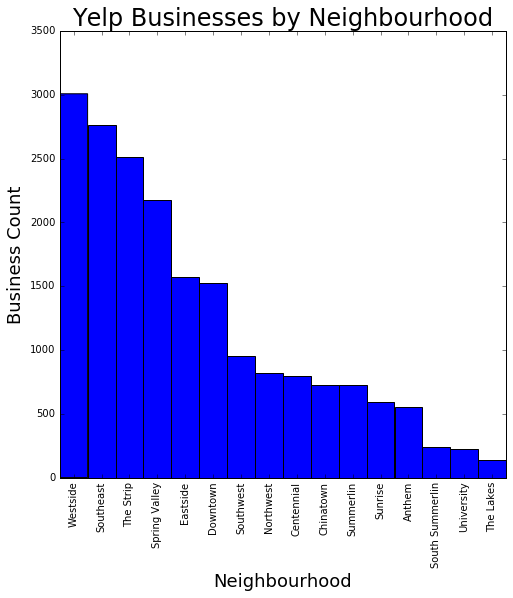

In [11]:
plt.figure(figsize=(8, 8))

#Find the 20 most common neighbourhoods
neighbourhood_tally = Counter(neighbourhood).most_common(20)

# Plot
ax = plt.axes()
x_val = [x[0] for x in neighbourhood_tally]
y_val = [x[1] for x in neighbourhood_tally]
plt.xlabel('Neighbourhood',fontsize=18)
plt.ylabel('Business Count',fontsize=18)
plt.title("Yelp Businesses by Neighbourhood",fontsize=24)
plt.xticks(range(len(neighbourhood_tally)),x_val, rotation='vertical')
plt.hist(range(len(neighbourhood_tally)), weights=y_val, bins=np.arange(len(neighbourhood_tally))+0.5)

plt.show()

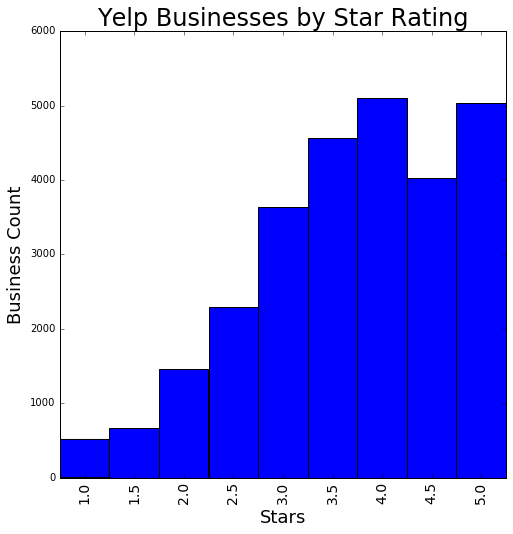

In [12]:
# Count stars
star_tally = sorted(Counter(stars).items())

# Plot
plt.figure(figsize=(8, 8))
ax = plt.axes()
x_val = [x[0] for x in star_tally]
y_val = [x[1] for x in star_tally]
plt.xlabel('Stars',fontsize=18)
plt.ylabel('Business Count',fontsize=18)
plt.title("Yelp Businesses by Star Rating",fontsize=24)
plt.xticks(range(len(star_tally)),x_val, rotation='vertical',fontsize=14)
plt.hist(range(len(star_tally)), weights=y_val, bins=np.arange(len(star_tally)+1)-0.5)

plt.show()

In [13]:
# Initialize lists to handle date data
days = []
ydays = []
months = []
years = []
day_names = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
month_names = ["January", "February", "March",
               "April", "May", "June",
               "July","August", "September",
               "October", "November", "December"]
leap_year = [2004, 2008, 2012, 2016]
count = 0

# Contruct lists of date information
for review in review_data:
    date = review["date"].split("-")
    days.append(day_names[datetime.datetime(int(date[0]),int(date[1]),int(date[2])).weekday()])
    months.append(month_names[int(date[1])-1])
    years.append(date[0])
    if(int(date[0]) not in leap_year and datetime.datetime(int(date[0]),int(date[1]),int(date[2])).timetuple().tm_yday > 59):
        ydays.append(datetime.datetime(int(date[0]),int(date[1]),int(date[2])).timetuple().tm_yday+1)
    else:
        ydays.append(datetime.datetime(int(date[0]),int(date[1]),int(date[2])).timetuple().tm_yday)

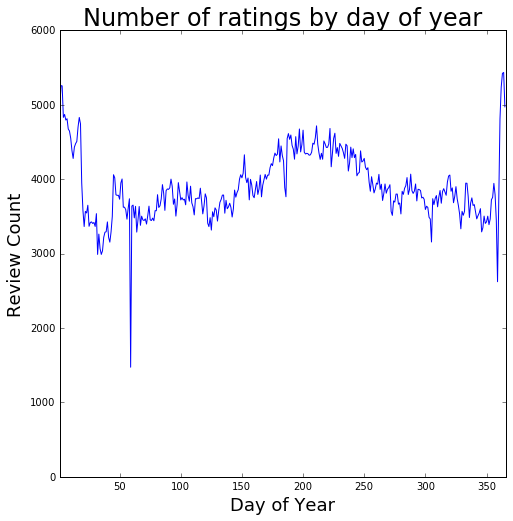

In [14]:
# Count days of year
ydays_tally = sorted(Counter(ydays).items())

# Plot
plt.figure(figsize=(8, 8))

x_val = [x[0] for x in ydays_tally]
y_val = [x[1] for x in ydays_tally]
plt.xlabel('Day of Year',fontsize=18)
plt.ylabel('Review Count',fontsize=18)
plt.title("Number of ratings by day of year",fontsize=24)
plt.axis([1, 366, 0, 6000])
plt.plot(y_val)

plt.savefig('reviewdayofyear.png')
plt.show()

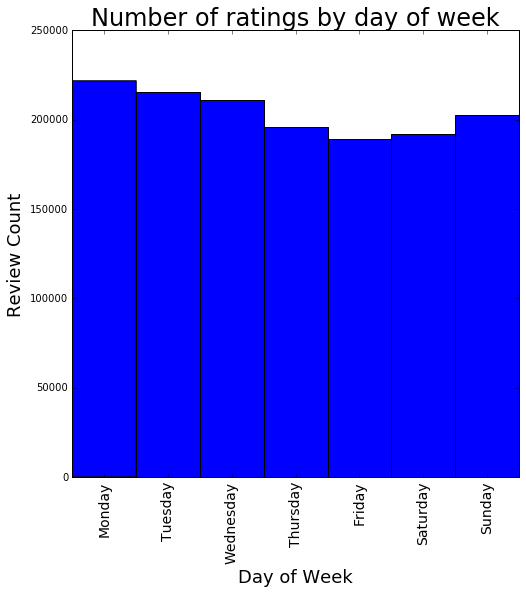

In [15]:
# Count reviews per days
days_tally = sorted(Counter(days).items())

# Plot
plt.figure(figsize=(8, 8))
temp = []
temp.append(days_tally[1])
temp.append(days_tally[5])
temp.append(days_tally[6])
temp.append(days_tally[4])
temp.append(days_tally[0])
temp.append(days_tally[2])
temp.append(days_tally[3])

days_tally = temp

x_val = [x[0] for x in days_tally]
y_val = [x[1] for x in days_tally]
plt.xlabel('Day of Week',fontsize=18)
plt.ylabel('Review Count',fontsize=18)
plt.title("Number of ratings by day of week",fontsize=24)

plt.xticks(range(len(days_tally)),x_val, rotation='vertical',fontsize=14)
plt.hist(range(len(days_tally)), weights=y_val, bins=np.arange(len(days_tally)+1)-0.5)

plt.savefig('reviewdayofweek.png')
plt.show()

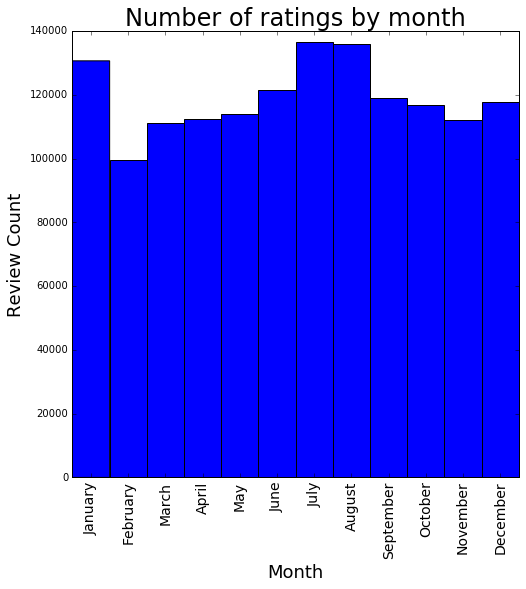

In [16]:
# Count reviews per months
month_tally = sorted(Counter(months).items())

# Plot
plt.figure(figsize=(8, 8))
temp = []
temp.append(month_tally[4])
temp.append(month_tally[3])
temp.append(month_tally[7])
temp.append(month_tally[0])
temp.append(month_tally[8])
temp.append(month_tally[6])
temp.append(month_tally[5])
temp.append(month_tally[1])
temp.append(month_tally[11])
temp.append(month_tally[10])
temp.append(month_tally[9])
temp.append(month_tally[2])

month_tally = temp

x_val = [x[0] for x in month_tally]
y_val = [x[1] for x in month_tally]
plt.xlabel('Month',fontsize=18)
plt.ylabel('Review Count',fontsize=18)
plt.title("Number of ratings by month",fontsize=24)

plt.xticks(range(len(month_tally)),x_val, rotation='vertical',fontsize=14)
plt.hist(range(len(month_tally)), weights=y_val, bins=np.arange(len(month_tally)+1)-0.5)

plt.show()

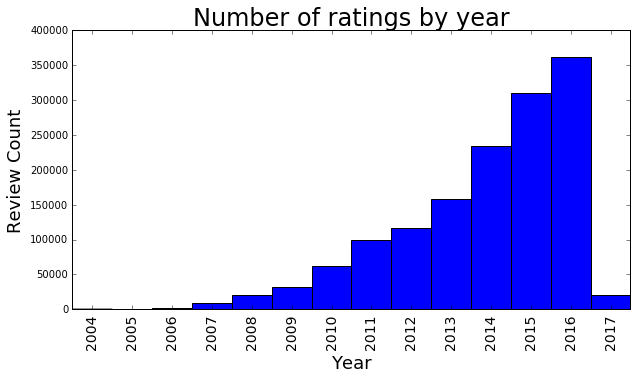

In [17]:
# Count review per years
year_tally = sorted(Counter(years).items())

plt.figure(figsize=(10, 5))

x_val = [x[0] for x in year_tally]
y_val = [x[1] for x in year_tally]
plt.xlabel('Year',fontsize=18)
plt.ylabel('Review Count',fontsize=18)
plt.title("Number of ratings by year",fontsize=24)
plt.xticks(range(len(year_tally)),x_val, rotation='vertical',fontsize=14)
plt.hist(range(len(year_tally)), weights=y_val, bins=np.arange(len(year_tally)+1)-0.5)

plt.show()

In [18]:
#Find yelp users
users = []

for review in review_data:
    users.append(review["user_id"])

print(len(users))

1427825


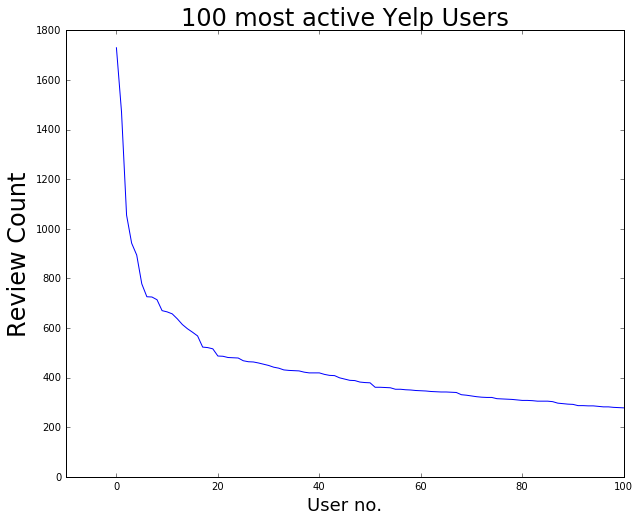

In [19]:
# PLot most active yelp users
plt.figure(figsize=(10, 8))
ydays_tally = Counter(users).most_common()

x_val = [x[0] for x in ydays_tally]
y_val = [x[1] for x in ydays_tally]
plt.xlabel('User no.',fontsize=18)
plt.ylabel('Review Count',fontsize=24)
plt.title("100 most active Yelp Users",fontsize=24)
plt.axis([-10, 100, 0, 1800])
plt.plot(y_val)

plt.savefig('100mostactive.png')
plt.show()

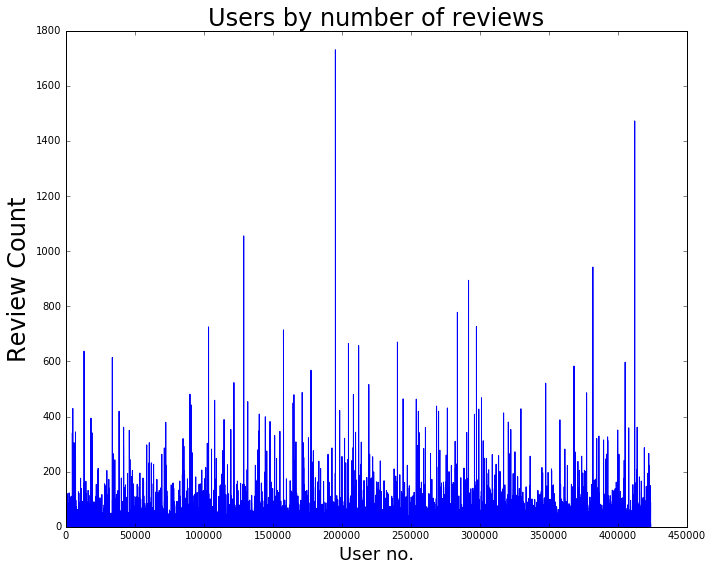

In [20]:
# Plot users by review count
plt.figure(figsize=(10, 8))
ydays_tally = Counter(users).items()

x_val = [x[0] for x in ydays_tally]
y_val = [x[1] for x in ydays_tally]
plt.xlabel('User no.',fontsize=18)
plt.ylabel('Review Count',fontsize=24)
plt.title("Users by number of reviews",fontsize=24)
plt.plot(y_val)
plt.tight_layout()

plt.savefig('100mostactive.png')
plt.show()

## Part 3: Theory

### Machine learning models and tools

Our Machine Learning approach is meant to answer whether or not we are ablt to predict the yelp star rating of business in Las Vegas given specific features. For this purpose we have preprocessed the data into numpy data structures. We mentioned One-Hot enconding earlier in this notebook. This is used to easily represent of a feature (attribute, category, hour) of a business is present. Must of the features we consider are binary (True/False) and the One-Hot encoding was chosen because of that. As mentioned we have preprocessed the data into an input matrix $X$ and an output vector $y$. We have star ratings in half-star intervals, i.e. the ratings is in {1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5}. We have chosen to solve the problem as a regression problem because we wanted to look at error measures for individual observations for our predictions, but we could also considered it as a classification problem.

We rely primarily on the scikit learn library in Python, and have used multiple tools from there. The following list shows tools used from scikit.

* RandomForestRegressor
* MLPRegressor
* svm
* ElasticNet (ElasticNetCV)
* LinearRegression
* train_test_split
* mean_squared_error
* cross_val_score
* sparse
* tree

The first 5 points are the regression models that we used to predict star ratings. We have chosen to use these models for various reasons. Some of them can naturally handle categorical values while others are very simple and easy to understand. It is also easy in all models to extract which features are the most important for predicting star ratings, which of course we are interested in. Some of the tools that we considered ended up not being used. E.g. svm (Support Vector Machine) is a Machine Learning model, but we chose to exclude because it was computationally expensive and did not give good results.

As an extra element we have included Word Cloud, because we have the texts of the business reviews and some words might be more frequent for high/low star ratings. This will also give some nice visualizations.

### Word Cloud

In this section we construct word clouds for each star rating. We do this by concatenating all review for a specific star rating into one large document. This gives us 5 documents of which we then find the term frequency–inverse document frequencies (TF-IDF). This gives us an idea of which words more frequent in the specific documents.

In [21]:
# Define function to tokenize and exclude the right elements from text like stopwords
def tokenize(text):
    # Tokenize text
    re_tokens = nltk.regexp_tokenize(text, r"\w+") 
    
    # Remove stopwords and standalone letters while setting to lowercase
    tokens = []
    for token in re_tokens:
        tokens.append(token.lower())
            
    return tokens

In [22]:
# Tokenize the review text and generate one large documents for each rating
docs = [[] for i in range(5)] #List to contain tokens for each review text for each rating

# For each review tokenize text and extend it to document
count = 0
print "Total review count: " + str(len(review_data))
for review in review_data:
    # Read and count review text from data
    rating = review['stars']
    tokens = list(set(tokenize(review['text']))) #List of unique words in review text
    docs[rating-1].extend(tokens)
    # Print progress
    count += 1
    if(count % 100000 == 0):
            print(count)
        
# Length of each document
for i in range(len(docs)):
    print len(docs[i])

Total review count: 1427825
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
17715707
11240716
15521759
27648430
40615791


A great tool for information retrievel is TF-IDF statistics. This stands for term frequency–inverse document frequency and is basically a way to determine how important words in a collection of documents are. This is why we combine review texts to large documents. Higher values in the TF-IDF vector means more important words. The TF-IDF vector for a collection document (representing say a partition into communities) will have TF-IDF values for each unique word in all the documents. We will represent TF-IDF vectors as dictionaries in python, keys being words and values being the calculated TF-IDF values. Term frequency (TF) is just how often a word appears in the documents. In this project simple raw term frequency is used. Inverse document frequency (IDF) is a measure of how common a word is by looking at how many different document it is in. IDF will therefore decrease the importance of very common words appearing in all review texts. The following code will find the TF-IDF vector for the one large document combining all reviews.

In [23]:
# Combine all steps of the TF-IDF approach in one function

def create_tf_idf(docs, log_base, output_option):
    # Convert lists of tokens to dictionaries of unique tokens with their count as values
    # This can be used for TF values for the large document
    token_dics = [{} for i in range(len(docs))]

    for idx, doc in enumerate(docs):
        token_dics[idx] = Counter(doc)
        # Print number of total count for each dictionary. Should be equal to length of each document
        print sum(token_dics[idx].values())

    # Calculate IDF
    token_idf = {} #Dictionary of each unique word in all documents with its IDF as value

    # Count occurence of each word in all the documents
    for doc in token_dics:
        for token in doc:
            if token not in token_idf:
                token_idf[token] = 1
            else:
                token_idf[token] += 1
    # Now calculate IDF for each word. Logarithm with log_base base is used
    for token in token_idf:
        token_idf[token] = math.log(float(len(docs))/(token_idf[token]), log_base)

    # Calcualte tf-idf for each document
    tf_idf = [{} for i in range(len(token_dics))] #List to contain TF-IDF for each token in each community
    for idx, doc in enumerate(token_dics):
        for token in doc:
            tf_idf[idx][token] = doc[token] * token_idf[token]
    
    if output_option == 'TF':
        return token_dics
    elif output_option == 'IDF':
        return token_idf
    elif output_option == 'TF-IDF':
        return tf_idf
    else:
        return "Invalid output_option"

While testing the TF-IDF approach and exploring the review text data we found that we got the most reasonable results when we considered the simple term frequency of words.

In [26]:
# Create TF-IDF values for each rating document
tf_idf = create_tf_idf(docs, 100, 'TF-IDF')

17715707
11240716
15521759
27648430
40615791


In [27]:
rating_idx = 4

# Convert tokens in documents into long strings using TF-IDF scores
text = ""
for token in tf_idf[rating_idx-1]:
    text = text + (' ' + token) * int(tf_idf[rating_idx-1][token])
            
print("Text created")

Text created


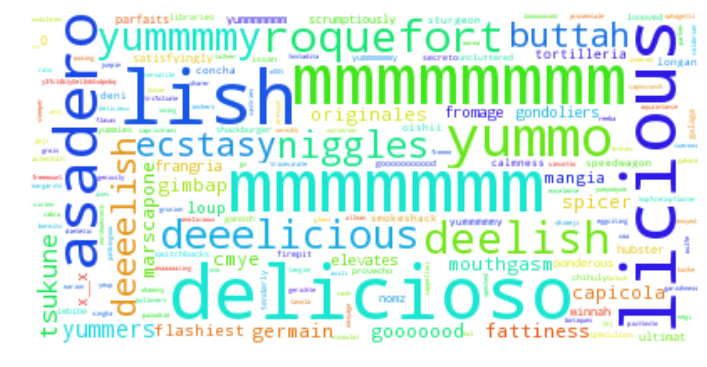

In [28]:
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=45,
                      background_color='white').generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")

pic_name = 'word_cloud_' + str(rating_idx) + '.png'
plt.savefig(pic_name)

plt.show()

### Model selection

We are working with multiple Machine Learning models in order to find the best way to predict yelp star ratings. In order to find the best regression model for predictions we have to evaluate their performances. We do this by splitting our data into a training and test set. The test set will only be used for meassuring the errors of our predictions and nothing else. We can easily split the data by using the test_train_split function from scikit learn on $X$ and $y$.

#### Tune parameters using Cross validation
The individual Machine Learning models have parameters that we can tune in order to optimize the models' performances. For example we are using the Random Forest regression model that constructs multiple Decision trees of a certain depth to predict a star rating. Depending on the number of Decision trees and their depth the Random Forest model performs differently. In order to find the best parameter we are going to use cross-validation. In models where there are more than one parameter to tune we use 2-fold cross-validation. Scikit learn provides an easy way to test which parameter makes the model give the best result. Cross_val_score gives of how well the model performed with the given parameters. The higher the score the better predictions (and the scores can be negative). Since their are no parameters to tune for Linear (Multiple) regression, no cross-validation is used on that model.

#### Split data

In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

### Model performance

As mentioned above we split the data into training and test set. The sole purpose of the test set is to be able to evaluate the final models, when we have tuned the parameters. This also means that we are tuning parameters of the models using __only__ the training data. When we evaluate a model either in the end or in the cross-validation we use the mean squared error as error measure. In the cross_val_score function we use the negative mean squared error because it is a scoring method and therefore have to be as high as possible. We want to compare the performance of our models with simple guessing. The highest frequent rating is 4, so we meassure the mean squared error of predictions that are all equal to 4. This gives us a value we can compare with.

#### Random guessing

In [30]:
# Predict on test data using guess on highest frequent rating
rating_guess = 4
y_guess = np.ones((len(y_test), 1)) * rating_guess
print('Guess on %f: %s' % (rating_guess, str(mean_squared_error(y_test, y_guess))))

Guess on 4.000000: 1.11599450046


### Machine Learning
In the following sections we create the different model, tune them and evaluate their performances.

### Random Forest Regression

In [31]:
# Create and train initial Random Forest model
regr_rf = RandomForestRegressor(max_depth=30, min_samples_split=100)
regr_rf.fit(X_train, y_train.ravel())
print('Completed training of initial Random Forest')

Completed training of initial Random Forest


In [32]:
# Predict on test data using Random Forest regression
y_rf = regr_rf.predict(X_test)
print('Random Forest: %s' % str(mean_squared_error(y_test, y_rf)))

Random Forest: 0.752655244757


In [33]:
# Show subsection of prediction along with true values
print(np.transpose(y_test))
print(y_rf)

[[ 5.   5.   2.5 ...,  4.   3.   4. ]]
[ 4.04982714  4.3799982   2.86616789 ...,  4.19707093  3.46956124
  3.42091453]


In [34]:
# Cross-validation on Random Forest model

K = 5 # K-fold cross-validation

num_trees = [5, 10, 20]
tree_depths = [10, 20, 30, 40, 50]

best_tree = [0,0]
best_cv_score = -1000

# First layer of cross validation
for num_tree in num_trees:
    print('Number of trees = %i' % num_tree)
    # Second layer of cross validation
    for tree_depth in tree_depths:
        regr_rf_CV = RandomForestRegressor(n_estimators=num_tree, max_depth=tree_depth)
        cv_score = np.mean(cross_val_score(regr_rf_CV,
                                           X_train,
                                           y_train.ravel(),
                                           cv=K, scoring='neg_mean_squared_error'))
        print('\tTree depth = %i: %f' % (tree_depth,cv_score))
        if cv_score > best_cv_score:
            best_cv_score = cv_score
            best_tree = [num_tree,tree_depth]

Number of trees = 5
	Tree depth = 10: -0.833967
	Tree depth = 20: -0.824661
	Tree depth = 30: -0.850615
	Tree depth = 40: -0.872436
	Tree depth = 50: -0.886445
Number of trees = 10
	Tree depth = 10: -0.822506
	Tree depth = 20: -0.799121
	Tree depth = 30: -0.804453
	Tree depth = 40: -0.816457
	Tree depth = 50: -0.826191
Number of trees = 20
	Tree depth = 10: -0.820562
	Tree depth = 20: -0.790304
	Tree depth = 30: -0.783499
	Tree depth = 40: -0.786438
	Tree depth = 50: -0.799765


In [35]:
# Prediction using tuned model

# Create and train Random Forest model
regr_rf = RandomForestRegressor(n_estimators=best_tree[0], max_depth=best_tree[1])
regr_rf.fit(X_train, y_train.ravel())
print('Completed training tuned of Random Forest')

Completed training tuned of Random Forest


In [36]:
# Predict on test data using Random Forest regression
y_rf = regr_rf.predict(X_test)
print('Random Forest: %s' % str(mean_squared_error(y_test, y_rf)))

Random Forest: 0.768597096401


In [37]:
# Predict on the entire dataset for D3 visualization
y_rf = regr_rf.predict(X)

rf_features = np.array([y[:,0],y_rf]).transpose()
# Convert features to list for JSON support
points = rf_features[rf_features[:, 0].argsort()].tolist()
d3data = {
    "points": points,
}

# Save as JSON file
with open('rf_preds_optimal.json', 'w') as outfile:
    json.dump(d3data, outfile)

### Multilayer perceptron Neural Network

In [38]:
# Create and train initial MLP neural network model
regr_mlp_nn = MLPRegressor(hidden_layer_sizes=(100, 10))
regr_mlp_nn.fit(X_train, y_train.ravel())
print('Completed training of inital MLP Neural Net')

Completed training of inital MLP Neural Net


In [39]:
# Predict on test data using MLP neural network
y_mlp_nn = regr_mlp_nn.predict(X_test)
print('MLP neural net: %s' % str(mean_squared_error(y_test, y_mlp_nn)))

MLP neural net: 0.733961572639


In [40]:
# Show subsection of prediction along with true values
print(np.transpose(y_test))
print(y_mlp_nn)

[[ 5.   5.   2.5 ...,  4.   3.   4. ]]
[ 4.0790091   4.55115399  2.87742083 ...,  3.94617469  3.16054033
  3.14570701]


In [41]:
# Cross-validation on MLP Neural Net model

K = 5 # K-fold cross-validation

num_components = [2,10,100]

best_components = (0, 0, 0)
best_cv_score = -1000

# First layer of cross validation
for layer_1 in num_components:
    # Second layer of cross validation
    for layer_2 in num_components:
        # Third layer of cross validation
        for layer_3 in num_components:
            regr_mlp_nn_CV = MLPRegressor(hidden_layer_sizes=(layer_1, layer_2, layer_3))
            cv_score = np.mean(cross_val_score(regr_mlp_nn_CV,
                                               X_train,
                                               y_train.ravel(),
                                               cv=K, scoring='neg_mean_squared_error'))
            print('Number of components in hidden layers = (%i,%i,%i): %f' % (layer_1,layer_2,layer_3,cv_score))
            if cv_score > best_cv_score:
                best_cv_score = cv_score
                best_components = (layer_1,layer_2,layer_3)

Number of components in hidden layers = (2,2,2): -1.025918
Number of components in hidden layers = (2,2,10): -0.863916
Number of components in hidden layers = (2,2,100): -0.768255
Number of components in hidden layers = (2,10,2): -0.970261
Number of components in hidden layers = (2,10,10): -0.751607
Number of components in hidden layers = (2,10,100): -0.766532
Number of components in hidden layers = (2,100,2): -0.974462
Number of components in hidden layers = (2,100,10): -0.861041
Number of components in hidden layers = (2,100,100): -0.813613
Number of components in hidden layers = (10,2,2): -0.925616
Number of components in hidden layers = (10,2,10): -0.867853
Number of components in hidden layers = (10,2,100): -0.804758
Number of components in hidden layers = (10,10,2): -0.766550
Number of components in hidden layers = (10,10,10): -0.758108
Number of components in hidden layers = (10,10,100): -0.751016
Number of components in hidden layers = (10,100,2): -0.871832
Number of components

In [42]:
# Prediction using tuned model
print((best_components, best_cv_score))
# Create and train tuned MLP neural network model
regr_mlp_nn = MLPRegressor(hidden_layer_sizes=best_components)
regr_mlp_nn.fit(X_train, y_train.ravel())
print('Completed training of tuned MLP Neural Net')

((10, 10, 100), -0.75101646462432181)
Completed training of tuned MLP Neural Net


In [43]:
# Predict on test data using MLP neural network
y_mlp_nn = regr_mlp_nn.predict(X_test)
print('MLP neural net: %s' % str(mean_squared_error(y_test, y_mlp_nn)))

MLP neural net: 0.732975517388


In [44]:
# Predict on the entire dataset for D3 visualization
y_nn = regr_mlp_nn.predict(X)

nn_features = np.array([y[:,0],y_nn]).transpose()

#Convert features to list for JSON support
points = nn_features[nn_features[:, 0].argsort()].tolist()
d3data = {
    "points": points,
}

# Save as JSON file
with open('nn_preds_optimal.json', 'w') as outfile:
    json.dump(d3data, outfile)

### Multiple Regression

In [45]:
# Create and train inital Linear (Multiple) regression model
regr_multi = LinearRegression()
regr_multi.fit(X_train, y_train.ravel())
print('Completed training of initial Multiple Regression')

/Users/tobiasslottjensen/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Completed training of initial Multiple Regression


In [46]:
# Predict on test data using Multiple Regression model
y_multi = regr_multi.predict(X_test)
print('Linear (Multiple) regression: %s' % str(mean_squared_error(y_test, y_multi)))

Linear (Multiple) regression: 0.756069800072


In [47]:
# Show subsection of prediction along with true values
print(np.transpose(y_test))
print(y_multi)

[[ 5.   5.   2.5 ...,  4.   3.   4. ]]
[ 4.01950497  4.46515561  2.85822162 ...,  3.87374833  3.27540033
  3.15500103]


In [48]:
# Predict on test data using Multiple Regression model
y_multi = regr_multi.predict(X_test)
print('Linear (Multiple) regression: %s' % str(mean_squared_error(y_test, y_multi)))

Linear (Multiple) regression: 0.756069800072


In [49]:
# Predict on the entire dataset for D3 visualization
y_mr = regr_multi.predict(X)

mr_features = np.array([y[:,0],y_mr]).transpose()

#Convert features to list for JSON support
points = mr_features[mr_features[:, 0].argsort()].tolist()
d3data = {
    "points": points,
}

# Save as JSON file
with open('mr_preds_optimal.json', 'w') as outfile:
    json.dump(d3data, outfile)

### Elastic Net with Lasso and Ridge Regression

In [50]:
# Create and train initial Elastic Net model (Lasso and Ridge)
regr_elastic = ElasticNet()
regr_elastic.fit(X_train, y_train.ravel())
print('Completed training of initial Elastic Net')

Completed training of initial Elastic Net


In [51]:
# Predict on test data using Elastic Net model
y_elastic = regr_elastic.predict(X_test)
print('Elastic Net: %s' % str(mean_squared_error(y_test, y_elastic)))

Elastic Net: 1.02377198232


In [52]:
# Show subsection of prediction along with true values
print(np.transpose(y_test))
print(y_elastic)

[[ 5.   5.   2.5 ...,  4.   3.   4. ]]
[ 3.68668731  3.69631131  3.68663003 ...,  3.68640088  3.6871456
  3.68663003]


In [53]:
# Cross-validation on Elastic Net model
regr_elastic_CV = ElasticNetCV(l1_ratio = np.linspace(0.0001, 1.0, num=20))
regr_elastic_CV.fit(X_train, y_train.ravel())
print('Completed training of Elastic Net CV')
best_ratio = regr_elastic_CV.l1_ratio_
print('Best l1 ratio: %f' % best_ratio)

Completed training of Elastic Net CV
Best l1 ratio: 1.000000


In [54]:
# Predict on test data using tuned Elastic Net model
y_elastic_CV = regr_elastic_CV.predict(X_test)
print('Elastic Net CV: %s' % str(mean_squared_error(y_test, y_elastic_CV)))

Elastic Net CV: 0.798066623195


In [55]:
# Prediction using tuned model

# Create and train tuned Elastic Net model (Lasso and Ridge)
regr_elastic = ElasticNet(l1_ratio=best_ratio)
regr_elastic.fit(X_train, y_train.ravel())
print('Completed training of tuned Elastic Net')

Completed training of tuned Elastic Net


In [56]:
# Predict on test data using Elastic Net model
y_elastic = regr_elastic.predict(X_test)
print('Elastic Net: %s' % str(mean_squared_error(y_test, y_elastic)))

Elastic Net: 1.02386154963


In [57]:
# Predict on the entire dataset for D3 visualization
y_ee = regr_elastic.predict(X)

ee_features = np.array([y[:,0],y_ee]).transpose()

#Convert features to list for JSON support
points = ee_features[ee_features[:, 0].argsort()].tolist()
d3data = {
    "points": points,
}

# Save as JSON file
with open('ee_preds_optimal.json', 'w') as outfile:
    json.dump(d3data, outfile)

### Feature selection

In this section we want to examine the most important features in the regression models. The build-in Random Forest model in scikit learn have an attribute indicating which features are of greater significance for the model. In the other models we have to look at the coeeficients in for the individual features to determine which has more relevance for the final prediction model.

In [58]:
# Important features in Random Forest
imp_features = np.where(abs(regr_rf.feature_importances_) > 0.005)[0]

print('Number of important features in Random Forest model: %i' % len(imp_features))

Number of important features in Random Forest model: 28


In [59]:
# Extract the most important features into list
imp_features_rf = []
for feature in imp_features:
    print(variables[feature] + ': ' +  str(regr_rf.feature_importances_[feature]))
    imp_features_rf.append((variables[feature], regr_rf.feature_importances_[feature]))

latitude: 0.115321050587
longitude: 0.119394208406
review_count: 0.090116500365
BikeParking: 0.00816041704653
BusinessAcceptsCreditCards: 0.0119404231306
ByAppointmentOnly: 0.0320514707058
GoodForKids: 0.00508876409022
WheelchairAccessible: 0.00770803390602
Active Life: 0.0100095472915
Apartments: 0.0268207422534
Banks & Credit Unions: 0.00899698747015
Doctors: 0.0140246727999
Drugstores: 0.00726593900312
Event Planning & Services: 0.00883026112018
Fast Food: 0.0271792975522
Fitness & Instruction: 0.00531154629497
Hair Salons: 0.00521628444444
Hotels & Travel: 0.0106233404781
Medical Centers: 0.00663684636583
Photographers: 0.00636242252664
Property Management: 0.00942689375036
Real Estate: 0.00968756246351
Real Estate Agents: 0.00635187661847
Restaurants: 0.0102484379814
Saturday: 0.0065917106987
Sunday: 0.0122892860131
Thursday: 0.0576810171306
Wednesday: 0.0110357906593


In [60]:
# Important features in Neural Net
imp_features = np.where(np.mean(abs(regr_mlp_nn.coefs_[0]), axis=1) > 0.005)[0]

print('Number of important features in Neural Net model: %i' % len(imp_features))

Number of important features in Neural Net model: 1085


In [61]:
# Extract the most important features into list
imp_features_mlp_nn = []
for feature in imp_features:
    print(variables[feature] + ': ' +  str(np.mean(abs(regr_mlp_nn.coefs_[0]), axis=1)[feature]))
    imp_features_mlp_nn.append((variables[feature], np.mean(abs(regr_mlp_nn.coefs_[0]), axis=1)[feature]))

latitude: 0.040220629466
longitude: 0.0348853290561
review_count: 0.0209459274871
AcceptsInsurance: 0.0646244360523
BYOB: 0.0808639241018
BikeParking: 0.0886293874477
BusinessAcceptsBitcoin: 0.0593438075337
BusinessAcceptsCreditCards: 0.0494801793242
ByAppointmentOnly: 0.0991764602816
Caters: 0.0712741559597
CoatCheck: 0.0501074656488
Corkage: 0.055425476432
DogsAllowed: 0.0726928404624
DriveThru: 0.152907665379
GoodForDancing: 0.0720911747138
GoodForKids: 0.0376623541285
HappyHour: 0.0649475962222
HasTV: 0.0335475167037
Open24Hours: 0.0419892229931
OutdoorSeating: 0.055736272451
RestaurantsCounterService: 0.0488668637057
RestaurantsDelivery: 0.0669854174914
RestaurantsGoodForGroups: 0.0423361144429
RestaurantsReservations: 0.0380246956557
RestaurantsTableService: 0.0668534642894
RestaurantsTakeOut: 0.066652326621
WheelchairAccessible: 0.0523988142252
africanamerican: 0.0297829080986
asian: 0.065275527971
background_music: 0.0404541824767
breakfast: 0.0653385712959
brunch: 0.0486077555

In [62]:
# Important features in Elastic Net
imp_features = np.where(abs(regr_elastic_CV.coef_) > 0.001)[0]

print('Number of important features in Elastic Net model: %i' % len(imp_features))

Number of important features in Elastic Net model: 83


In [63]:
# Extract the most important features into list
imp_features_elastic = []
for feature in imp_features:
    print(variables[feature] + ': ' +  str(regr_elastic_CV.coef_[feature]))
    imp_features_elastic.append((variables[feature], regr_elastic_CV.coef_[feature]))

longitude: -0.00144808472565
AcceptsInsurance: -0.0663155877139
BikeParking: 0.0663402806585
BusinessAcceptsCreditCards: 0.0254287328298
ByAppointmentOnly: 0.375958757145
Caters: 0.129184511887
DogsAllowed: 0.138354013381
DriveThru: -0.211487329446
GoodForKids: 0.0600050917939
HasTV: 0.0230020412174
RestaurantsReservations: 0.00794355382279
RestaurantsTakeOut: -0.115024981397
WheelchairAccessible: 0.109192088682
dinner: 0.0135694892204
dj: -0.106650702663
garage: -0.0607528324951
street: 0.0990945127255
Accessories: 0.00619666212142
Active Life: 0.254480626166
American (Traditional): -0.0787766247964
Apartments: -0.674402534724
Arts & Entertainment: 0.0180521874405
Auto Customization: 0.0235275583993
Automotive: 0.0354441631762
Banks & Credit Unions: -0.490607607338
Beauty & Spas: 0.104916354869
Buffets: -0.235398413327
Burgers: -0.0401222684809
Car Dealers: -0.108464897114
Chinese: -0.124940032699
Chiropractors: 0.321683247542
Coffee & Tea: -0.0494806946884
Convenience Stores: -0.1298

In [64]:
# Important features in Multiple regression model
imp_features = np.where(abs(regr_multi.coef_) > 1)[0]

print('Number of important features in Multiple regression model: %i' % len(imp_features))

Number of important features in Multiple regression model: 65


In [65]:
# Extract the most important features into list
imp_features_multi = []
for feature in imp_features:
    print(variables[feature] + ': ' +  str(regr_multi.coef_[feature]))
    imp_features_multi.append((variables[feature], regr_multi.coef_[feature]))

Aircraft Repairs: -1.67615358711
Airsoft: -1.67615358711
Anesthesiologists: -1.00274798258
Art Restoration: 1.09659395514
Art Tours: 1.02493286723
Audiologist: 1.17768430391
Awnings: 1.02088294828
Bar Crawl: 1.04409786572
Bartending Schools: 1.16081611963
Basque: -1.13381763268
Beer Garden: -1.00001161956
Beverage Store: 1.30308068956
Boat Tours: -1.1166906542
Cannabis Tours: 1.50268367208
Clothing Rental: 1.10191877398
Clowns: -1.10642955557
Coffee Roasteries: 1.05349203525
Comic Books: 1.04508181909
Contract Law: -1.03551907404
Currency Exchange: 1.91205289068
DIY Auto Shop: 1.33997595156
Dance Wear: 1.47803158445
Emergency Medicine: 1.31431969048
Ethnic Grocery: -1.34042131843
Farming Equipment: -1.0255656317
Fingerprinting: 1.09839431223
Firewood: 1.17344242216
Float Spa: -1.00020665493
Food Banks: 1.14570157084
Fuel Docks: -1.54234358797
Fur Clothing: -2.753320837
Guest Houses: 1.21638591623
Hindu Temples: 1.19781848727
Home Theatre Installation: 1.06504556363
House Sitters: 2.583

In [66]:
# Find features that are important for the two most models with best predictions
common_imp_features = list(set([feature[0] for feature in imp_features_rf])
     .intersection(set([feature[0] for feature in imp_features_mlp_nn])))

print common_imp_features

['Drugstores', 'Thursday', 'BusinessAcceptsCreditCards', 'Sunday', 'Fast Food', 'Banks & Credit Unions', 'Hair Salons', 'review_count', 'Fitness & Instruction', 'Photographers', 'BikeParking', 'Doctors', 'latitude', 'GoodForKids', 'Hotels & Travel', 'Wednesday', 'ByAppointmentOnly', 'Restaurants', 'Apartments', 'longitude', 'Active Life', 'Property Management', 'Real Estate Agents', 'WheelchairAccessible', 'Real Estate', 'Medical Centers', 'Saturday', 'Event Planning & Services']


Based on the measured prediction errors and by plotting the predicted values from the models with the true ratings we find that the best model in this project is the Random Forest model. This model managed to predict better than random guessing and have a reasonable computational time. It also provides an easy way to extract important features for predicting star rating, as scikit learn RandomForestRegressor has the built-in attribute feature\_importances\_. There are some of the other model that approximately have the same test performance but when we plot the prediction using D3 the decision is easier. We expected to be able to predict reviews better than random guessing and wanted to find important features for rating predictions. This can be done using the Random Forest model and it doesn't hurt to tune the parameters a bit to improve its performance.

## Part 4: Visualizations

Most of our visualizations are created using D3. A significant part of this project was to construct good D3 plots of error measurements, summary statistics and an interactive map of Las Vegas businesses. The goal is to predict review ratings and for this we need to know where high rated businesses are and why the recieved the rating. Our data exploration and D3 visualizations help us do that.

We predict ratings using Machine Learning methods. We construct models and need to evaluate these to see if they perform reasonbly and make sense. We can measure the performance using mean squared error, but we also need to see if the predictions equals the true ratings. Predictions and test data are compared in D3 plots, so we can discuss which model is the best.

As mentioned earlier we found that Random Forest regression seemed to be the best model. The Neural Network model also performed well considering mean squared error. We want to explain both of these models to a reader of the webpage without a deeper technical understanding, so we construct simple plots of these models below.

Since we want to predict ratings using Machine Learning we need to be able to explain our approach and data exploration, which is done best using visualizations.

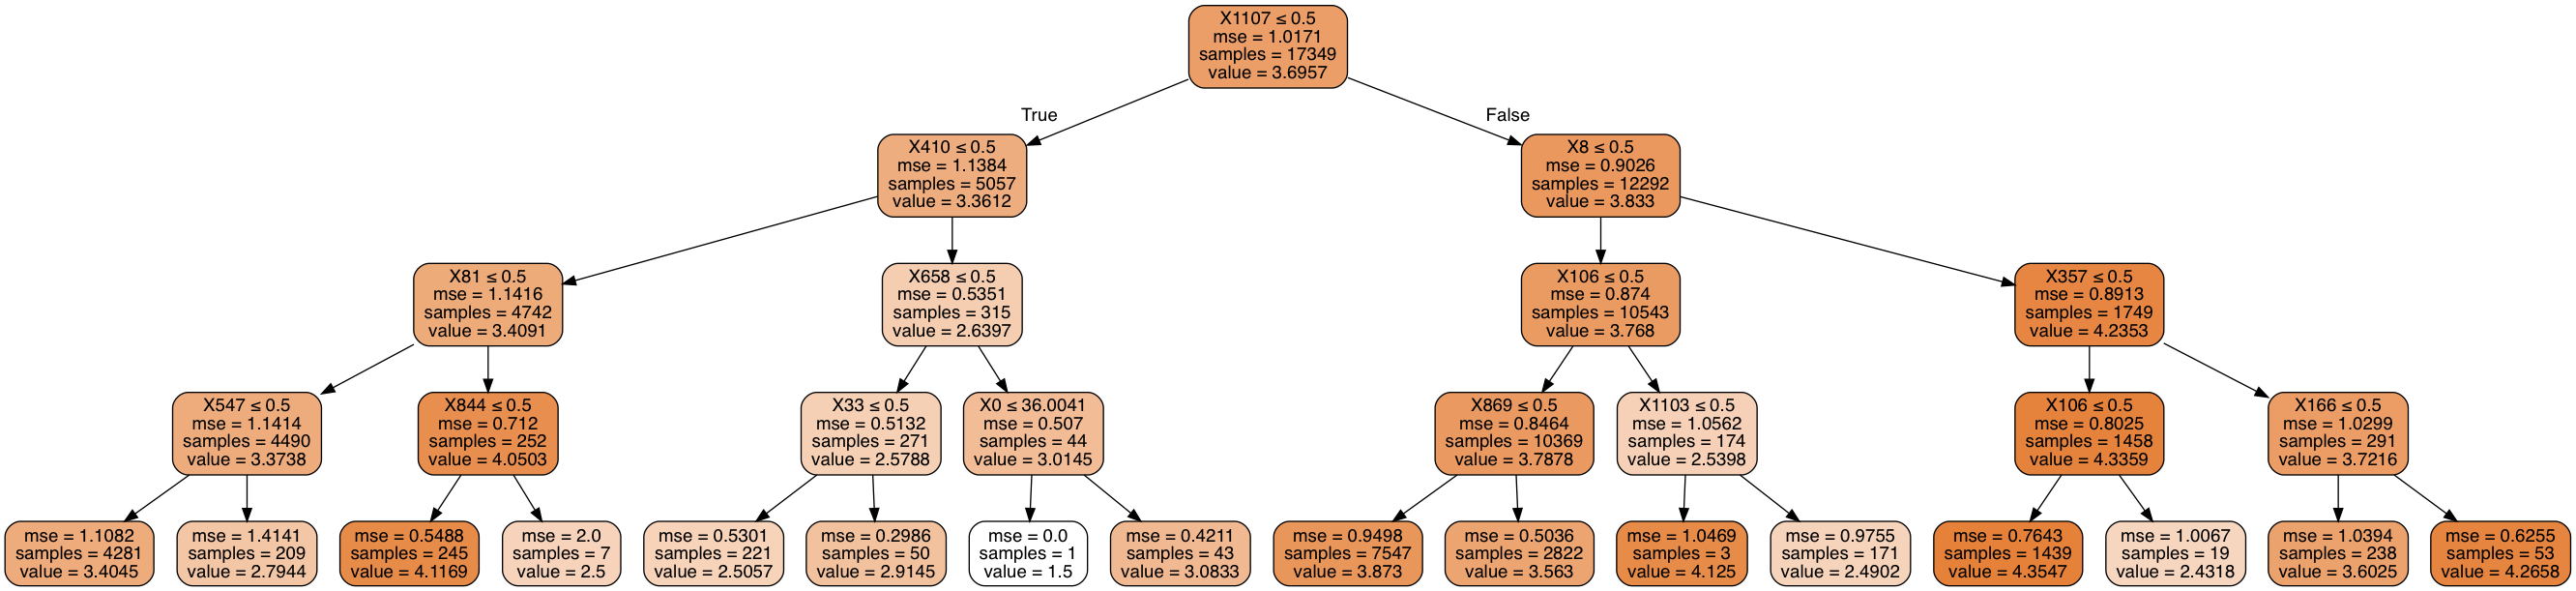

In [67]:
# Plot a tree from example Random Forest

# Create and train example Random Forest model
regr_rf_exp = RandomForestRegressor(n_estimators=5,max_depth=4)
regr_rf_exp.fit(X, y.ravel())

# Plot and save one Decision tree from the Random Forest
dot_data = tree.export_graphviz(regr_rf_exp.estimators_[0], out_file=None,
                                filled=True, rounded=True, special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data)
graph.write_pdf("tree.pdf")
Image(graph.create_png())

The following code is only used to construct a simple plot of a Neural Network. The block of code was found [here](http://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network), courtesy of user Oli Blum on Stackoverflow.

In [68]:
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in xrange(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = plt.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        plt.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            plt.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            plt.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            plt.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        plt.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        plt.title( 'Neural Network architecture', fontsize=15 )
        plt.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

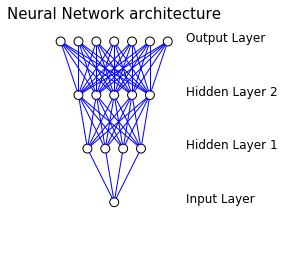

In [69]:
# Plot Neural Net
network = DrawNN( [1,4,5,7] )
network.draw()
plt.savefig('neural_net.png')

## Part 5: Discussion

The central themes of the course has been to analyze data with Machine Learning and visualize data in smart ways using D3. We have tried to incorporate this in our project. After we completed the data preprocessing we managed to try a couple Machine Learning regression models, but more importantly we got to tune the models. This allowed us to predict somewhat better than guessing on the most frequent rating. We also put a lot of work into an interactive map and statistics of Las Vegas businesses. These D3 visualizations can be seen on the webpage.

If we have had more time to improve the project we would have explored some of our additional ideas for the Yelp Dataset challenge. Such as looking at more than just the business data file, examining seasonal trends in data and trying to detect if some users stood out in all the reviews. We would have liked to go more in depth with D3 visualization for the error measures and the parameter tuning in Machine Learning. If time had allowed it we would have examined seasonal trends as the data contains date information about the reviews. Maybe we could detect some spikes in review rating around vacation time or something entirely unexpected. We could have explored the Yelp dataset more by also focusing on yelp users and the reviews they give. Some people might be trendsetters that predicts which places are up and coming, and some people might not be people but rating bots designed to improve the average rating of a business.

The important topics from data analysis used in this project are Regression models, parameter tuning in prediction models and feature selection. We made an interactive map with filtering options along with clear and concise bar and line plots with dynamic tooltips, which allowed us to really the many possibilities of D3 visualizations. 